## Data Analysis

In [122]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
import seaborn as sns
import re
from collections import defaultdict
from IPython.display import display, HTML


### dataset table

In [3]:
dataset = load_dataset("rokokot/question-type-and-complexity", name="base", split="train")
lang_map = {'ar': 'Arabic', 'en': 'English', 'fi': 'Finnish','id': 'Indonesian', 'ja': 'Japanese','ko': 'Korean', 'ru': 'Russian'}

splits = ['train', 'validation', 'test']
all_results = []

for split in splits:
  dataset = load_dataset('rokokot/question-type-and-complexity', name='base', split=split)
  
  for lang in list(lang_map.keys()):
    lang_data = dataset.filter(lambda x: x['language'] == lang)

    n_questions = len(lang_data)

    question_types = lang_data['question_type']

    polar_count = sum(1 for qt in question_types if qt == 1)
    content_count = sum(1 for qt in question_types if qt == 0)

    polar_pct = round((polar_count / n_questions) * 100, 1)
    content_pct = round((content_count / n_questions) * 100, 1)

    avg_complexity = round(np.mean(lang_data['complexity_score']), 2)

    all_results.append({'Language': lang_map[lang],'Questions': n_questions,'Polar (%)': polar_pct,'Content (%)': content_pct,'Avg. Complexity': avg_complexity})
stats_df = pd.DataFrame(all_results)
print(stats_df.to_string(index=False))

  Language  Questions  Polar (%)  Content (%)  Avg. Complexity
    Arabic        995       49.9         50.1             1.50
   English       1192       50.0         50.0             1.60
   Finnish       1195       50.0         50.0             1.37
Indonesian        954       47.9         52.1             1.86
  Japanese       1191       50.0         50.0             1.60
    Korean        739       46.1         53.9             1.97
   Russian       1194       50.0         50.0             1.76
    Arabic         44       45.5         54.5             1.73
   English         72       50.0         50.0             1.74
   Finnish         63       47.6         52.4             1.64
Indonesian         72       50.0         50.0             2.01
  Japanese         46       52.2         47.8             1.71
    Korean         72       50.0         50.0             2.05
   Russian         72       50.0         50.0             1.83
    Arabic         77       28.6         71.4          

In [3]:
def analyze_averages():
    splits = ["train", "validation", "test"]
    lang_map = {
        'ar': 'Arabic', 'en': 'English', 'fi': 'Finnish',
        'id': 'Indonesian', 'ja': 'Japanese',
        'ko': 'Korean', 'ru': 'Russian'
    }
    
    combined_stats = {lang: {'Questions': 0, 'Polar': 0, 'Content': 0, 'Complexity': []} 
                     for lang in lang_map.values()}
    
    total_questions = 0

    for split in splits:
        try:
            dataset = load_dataset("rokokot/question-type-and-complexity", name="base", split=split)
            
            for lang_code, lang_name in lang_map.items():
                lang_data = dataset.filter(lambda x: x['language'] == lang_code)
                
                if len(lang_data) == 0:
                    print(f"No data for {lang_name} in {split} split")
                    continue
                
                combined_stats[lang_name]['Questions'] += len(lang_data)
                total_questions += len(lang_data)
                
                question_types = lang_data['question_type']
                polar_count = sum(1 for qt in question_types if qt == 1)
                combined_stats[lang_name]['Polar'] += polar_count
                combined_stats[lang_name]['Content'] += (len(lang_data) - polar_count)
                
                combined_stats[lang_name]['Complexity'].extend(lang_data['complexity_score'])
                
        except Exception as e:
            print(f"Error processing {split} split: {e}")
    
    results = []
    for lang_name, stats in combined_stats.items():
        if stats['Questions'] > 0:
            polar_pct = round((stats['Polar'] / stats['Questions']) * 100, 1)
            content_pct = round((stats['Content'] / stats['Questions']) * 100, 1)
            avg_complexity = round(np.mean(stats['Complexity']), 2) if stats['Complexity'] else 0
            dataset_pct = round((stats['Questions'] / total_questions) * 100, 1)

            results.append({'Language': lang_name,'Dataset %': dataset_pct,'Polar %': polar_pct,'Content %': content_pct,'Avg. Complexity': avg_complexity
            })
    
    stats_df = pd.DataFrame(results)
    
    return stats_df

stats_df = analyze_averages()
print(stats_df.to_string(index=False))


  Language  Dataset %  Polar %  Content %  Avg. Complexity
    Arabic       12.9     48.3       51.7             1.55
   English       15.9     50.0       50.0             1.61
   Finnish       15.9     49.9       50.1             1.40
Indonesian       13.2     48.2       51.8             1.88
  Japanese       15.4     50.8       49.2             1.66
    Korean       10.7     46.9       53.1             1.98
   Russian       16.0     50.0       50.0             1.76


In [59]:
original_df = pd.read_csv("/home/robin/Research/qtype-eval/visualization/base_csv_files/original_base.csv")
probe_df = pd.read_csv("/home/robin/Research/qtype-eval/visualization/base_csv_files/probe_base.csv")
finetune_df = pd.read_csv("/home/robin/Research/qtype-eval/visualization/base_csv_files/finetune_base.csv")

In [ ]:
target_columns = [
    'language', 'real', 'control1', 'control2', 'control3', 'control_mean', 
    'selectivity', 'normalized_selectivity', 'task', 'model_type', 'metric', 'submetric'
]

In [66]:
original_filtered = original_df[original_df['model_type'] != 'lm_probe'].copy()
original_filtered = original_filtered[original_filtered['split'] == 'test'].copy()
finetune_real = finetune_df[finetune_df['control_index'].isna()].copy()

In [72]:
finetune_real.tail(100)

,experiment_type,language,task,submetric,control_index,metric,value
320,finetune,fi,single_submetric,n_tokens,NaN,loss,0.011284
321,finetune,fi,single_submetric,n_tokens,NaN,mse,0.011379
322,finetune,fi,single_submetric,n_tokens,NaN,rmse,0.106674
323,finetune,fi,single_submetric,n_tokens,NaN,r2,0.176997
324,finetune,id,single_submetric,avg_links_len,NaN,loss,0.031529
...,...,...,...,...,...,...,...
415,finetune,ru,single_submetric,lexical_density,NaN,r2,-0.067467
416,finetune,ru,single_submetric,n_tokens,NaN,loss,0.005862
417,finetune,ru,single_submetric,n_tokens,NaN,mse,0.005938
418,finetune,ru,single_submetric,n_tokens,NaN,rmse,0.077056


In [68]:
print(f"Selected {len(finetune_real)} rows from finetune data where control_index is None")

finetune_processed = pd.DataFrame()
finetune_processed['language'] = finetune_real['language']
finetune_processed['real'] = finetune_real['value']
finetune_processed['task'] = finetune_real['task']
finetune_processed['metric'] = finetune_real['metric']
finetune_processed['submetric'] = finetune_real['submetric']
finetune_processed['model_type'] = 'finetune'
finetune_processed['control1'] = np.nan
finetune_processed['control2'] = np.nan
finetune_processed['control3'] = np.nan
finetune_processed['control_mean'] = np.nan
finetune_processed['selectivity'] = np.nan
finetune_processed['normalized_selectivity'] = np.nan


Selected 231 rows from finetune data where control_index is None


In [77]:
finetune_processed.head(5)

,language,real,task,metric,submetric,model_type,control1,control2,control3,control_mean,selectivity,normalized_selectivity
0,ar,0.042425,complexity,loss,NaN,finetune,NaN,NaN,NaN,NaN,NaN,NaN
1,ar,0.042143,complexity,mse,NaN,finetune,NaN,NaN,NaN,NaN,NaN,NaN
2,ar,0.205289,complexity,rmse,NaN,finetune,NaN,NaN,NaN,NaN,NaN,NaN
3,ar,0.273465,complexity,r2,NaN,finetune,NaN,NaN,NaN,NaN,NaN,NaN
4,ar,0.742846,question_type,loss,NaN,finetune,NaN,NaN,NaN,NaN,NaN,NaN


In [117]:

original_df = pd.read_csv("/home/robin/Research/qtype-eval/visualization/base_csv_files/original_base.csv")
probe_df = pd.read_csv("/home/robin/Research/qtype-eval/visualization/base_csv_files/probe_base.csv")
finetune_df = pd.read_csv("/home/robin/Research/qtype-eval/visualization/base_csv_files/finetune_base.csv")

target_columns = [
    'language', 'real', 'control1', 'control2', 'control3', 'control_mean', 
    'selectivity', 'normalized_selectivity', 'task', 'model_type', 'metric', 'submetric', 'split', 'layer'
]

print("Filtering original data...")
original_filtered = original_df[original_df['model_type'] != 'lm_probe'].copy()
original_filtered = original_filtered[original_filtered['split'] == 'test'].copy()

original_filtered['layer'] = None

print("Processing finetune data...")
finetune_real = finetune_df[finetune_df['control_index'].isna()].copy()
print(f"Selected {len(finetune_real)} rows from finetune data where control_index is None")

finetune_processed = pd.DataFrame()
finetune_processed['language'] = finetune_real['language']
finetune_processed['real'] = finetune_real['value']
finetune_processed['task'] = finetune_real['task']
finetune_processed['metric'] = finetune_real['metric']
finetune_processed['submetric'] = finetune_real['submetric']
finetune_processed['model_type'] = 'finetune'
finetune_processed['split'] = 'test'
finetune_processed['layer'] = 'None'  # Explicitly set to None for finetune experiments
finetune_processed['control1'] = 'None'
finetune_processed['control2'] = 'None'
finetune_processed['control3'] = 'None'
finetune_processed['control_mean'] = 'None'
finetune_processed['selectivity'] = 'None'
finetune_processed['normalized_selectivity'] = 'None'

# Step 3: Process probe data - IMPROVED APPROACH with proper layer handling
print("Processing probe data with improved control extraction...")

# Get all unique combinations of parameters 
unique_combinations = probe_df.drop_duplicates(
    subset=['language', 'task', 'submetric', 'metric', 'layer_index']
).copy()

print(f"Found {len(unique_combinations)} unique parameter combinations in probe data")

# Process each unique combination
results = []
for _, row in unique_combinations.iterrows():
    language = row['language']
    task = row['task']
    submetric = row['submetric']
    metric = row['metric']
    layer_idx = row['layer_index']
    
    # Get all rows matching this combination
    matching_rows = probe_df[
        (probe_df['language'] == language) & 
        (probe_df['task'] == task) & 
        (probe_df['submetric'] == submetric) & 
        (probe_df['metric'] == metric) & 
        (probe_df['layer_index'] == layer_idx)
    ]
    
    # Skip if no matching rows
    if len(matching_rows) == 0:
        continue
    
    # Create a new row for this combination
    result_row = {
        'language': language,
        'task': task,
        'submetric': submetric,
        'metric': metric,
        'model_type': 'probe',
        'split': 'test',
        'layer': f'layer{layer_idx}'  # Properly include layer information for probe experiments
    }
    
    # Find real value (NaN control_index)
    real_rows = matching_rows[matching_rows['control_index'].isna()]
    if len(real_rows) > 0:
        result_row['real'] = real_rows.iloc[0]['value']
    else:
        # Skip if no real value found
        print(f"Warning: No real value found for {language}/{task}/{metric}")
        continue
    
    # Find control values
    for control_idx in [1.0, 2.0, 3.0]:
        control_rows = matching_rows[matching_rows['control_index'] == control_idx]
        if len(control_rows) > 0:
            result_row[f'control{int(control_idx)}'] = control_rows.iloc[0]['value']
    
    # Calculate control_mean if we have at least one control
    controls = []
    for control_key in ['control1', 'control2', 'control3']:
        if control_key in result_row and pd.notna(result_row.get(control_key)):
            try:
                controls.append(float(result_row[control_key]))
            except (ValueError, TypeError):
                pass
    
    if controls:
        result_row['control_mean'] = sum(controls) / len(controls)
        
        if pd.notna(result_row.get('real')):
            try:
                real_val = float(result_row['real'])
                control_mean = float(result_row['control_mean'])
                result_row['selectivity'] = abs(real_val - control_mean)
                
                # Calculate normalized_selectivity
                if control_mean != 0:
                    result_row['normalized_selectivity'] = (abs(real_val - control_mean) / control_mean) * 100
                else:
                    result_row['normalized_selectivity'] = 0
            except (ValueError, TypeError):
                pass
    
    # Add to our results
    results.append(result_row)

# Convert to DataFrame
probe_processed = pd.DataFrame(results)
print(f"Created {len(probe_processed)} processed probe rows")

# Print a diagnosis of tasks in the probe data for debugging
print("\nTask breakdown in processed probe data:")
task_counts = probe_processed['task'].value_counts()
print(task_counts)

# Step 4: Merge all datasets
print("\nMerging datasets...")

# Ensure all DataFrames have all required columns
for df in [original_filtered, probe_processed, finetune_processed]:
    for col in target_columns:
        if col not in df.columns:
            df[col] = np.nan

# Combine all processed data
merged_df = pd.concat(
    [
        original_filtered[target_columns],
        probe_processed[target_columns],
        finetune_processed[target_columns]
    ],
    ignore_index=True
)

# Fill NaN values in the 'split' column with 'test'
merged_df['split'] = merged_df['split'].fillna('test')

# Save the result
output_file = '/home/robin/Research/qtype-eval/visualization/notebooks/merged_ml_results.csv'
merged_df.to_csv(output_file, index=False)

print(f"\nSuccessfully created {output_file}")
print(f"Total rows: {len(merged_df)}")
print(f"  - Original data: {len(original_filtered)}")
print(f"  - Probe data: {len(probe_processed)}")
print(f"  - Finetune data: {len(finetune_processed)}")

# Display some diagnostics about layer values
print("\nLayer value counts:")
layer_counts = merged_df['layer'].value_counts(dropna=False)
print(layer_counts)

# Check each model type for proper layer handling
print("\nChecking layer values by model_type:")
for model_type in merged_df['model_type'].unique():
    model_data = merged_df[merged_df['model_type'] == model_type]
    layer_values = model_data['layer'].value_counts(dropna=False)
    print(f"\n{model_type}:")
    print(layer_values)

Filtering original data...
Processing finetune data...
Selected 231 rows from finetune data where control_index is None
Processing probe data with improved control extraction...
Found 2772 unique parameter combinations in probe data
Created 2016 processed probe rows

Task breakdown in processed probe data:
task
single_submetric    2016
Name: count, dtype: int64

Merging datasets...

Successfully created /home/robin/Research/qtype-eval/visualization/notebooks/merged_ml_results.csv
Total rows: 2415
  - Original data: 168
  - Probe data: 2016
  - Finetune data: 231

Layer value counts:
layer
None       231
None       168
layer1     168
layer2     168
layer3     168
layer4     168
layer5     168
layer6     168
layer7     168
layer8     168
layer9     168
layer10    168
layer11    168
layer12    168
Name: count, dtype: int64

Checking layer values by model_type:

DummyRegressor:
layer
None    49
Name: count, dtype: int64

XGBRegressor:
layer
None    49
Name: count, dtype: int64

DummyClassi

In [ ]:
import pandas as pd
import numpy as np

original_df = pd.read_csv("/home/robin/Research/qtype-eval/visualization/base_csv_files/original_base.csv")
probe_df = pd.read_csv("/home/robin/Research/qtype-eval/visualization/base_csv_files/probe_base.csv")
finetune_df = pd.read_csv("/home/robin/Research/qtype-eval/visualization/base_csv_files/finetune_base.csv")

# Define the target columns and their order for the final dataset
target_columns = [
    'language', 'task', 'submetric', 'model_type', 'layer', 'metric', 
    'real', 'control1', 'control2', 'control3', 'control_mean', 'split'
]

print("Filtering original data...")
original_filtered = original_df[original_df['model_type'] != 'lm_probe'].copy()
original_filtered = original_filtered[original_filtered['split'] == 'test'].copy()

# Set layer to None for original data
original_filtered['layer'] = None

print("Processing finetune data...")
# Process finetune data (keeping this as it is in the original script)
finetune_real = finetune_df[finetune_df['control_index'].isna()].copy()
print(f"Selected {len(finetune_real)} rows from finetune data where control_index is None")

finetune_processed = pd.DataFrame()
finetune_processed['language'] = finetune_real['language']
finetune_processed['real'] = finetune_real['value']
finetune_processed['task'] = finetune_real['task']
finetune_processed['metric'] = finetune_real['metric']
finetune_processed['submetric'] = finetune_real['submetric'] 
finetune_processed['model_type'] = 'finetune'
finetune_processed['split'] = 'test'
finetune_processed['layer'] = 'None'  # Set to None for finetune experiments
finetune_processed['control1'] = 'None'
finetune_processed['control2'] = 'None'
finetune_processed['control3'] = 'None'
finetune_processed['control_mean'] = 'None'

# Process probe data without selectivity calculations
print("Processing probe data...")

# Get all unique combinations of parameters
unique_combinations = probe_df.drop_duplicates(
    subset=['language', 'task', 'submetric', 'metric', 'layer_index']
).copy()

print(f"Found {len(unique_combinations)} unique parameter combinations in probe data")

# Process each unique combination
results = []
for _, row in unique_combinations.iterrows():
    language = row['language']
    task = row['task']
    submetric = row['submetric']
    metric = row['metric']
    layer_idx = row['layer_index']
    
    # Get all rows matching this combination
    matching_rows = probe_df[
        (probe_df['language'] == language) & 
        (probe_df['task'] == task) & 
        (probe_df['submetric'] == submetric) & 
        (probe_df['metric'] == metric) & 
        (probe_df['layer_index'] == layer_idx)
    ]
    
    # Skip if no matching rows
    if len(matching_rows) == 0:
        continue
    
    # Create a new row for this combination
    result_row = {
        'language': language,
        'task': task,
        'submetric': submetric,
        'metric': metric,
        'model_type': 'probe',
        'split': 'test',
        'layer': f'layer{layer_idx}'  # Include layer information for probe experiments
    }
    
    # Find real value (NaN control_index)
    real_rows = matching_rows[matching_rows['control_index'].isna()]
    if len(real_rows) > 0:
        result_row['real'] = real_rows.iloc[0]['value']
    else:
        # Skip if no real value found
        print(f"Warning: No real value found for {language}/{task}/{metric}")
        continue
    
    # Find control values
    for control_idx in [1.0, 2.0, 3.0]:
        control_rows = matching_rows[matching_rows['control_index'] == control_idx]
        if len(control_rows) > 0:
            result_row[f'control{int(control_idx)}'] = control_rows.iloc[0]['value']
    
    # Calculate control_mean if we have at least one control
    controls = []
    for control_key in ['control1', 'control2', 'control3']:
        if control_key in result_row and pd.notna(result_row.get(control_key)):
            try:
                controls.append(float(result_row[control_key]))
            except (ValueError, TypeError):
                pass
    
    if controls:
        result_row['control_mean'] = sum(controls) / len(controls)
    
    # Add to our results
    results.append(result_row)

# Convert to DataFrame
probe_processed = pd.DataFrame(results)
print(f"Created {len(probe_processed)} processed probe rows")

# Print a diagnosis of tasks in the probe data for debugging
print("\nTask breakdown in processed probe data:")
task_counts = probe_processed['task'].value_counts()
print(task_counts)

# Merge all datasets
print("\nMerging datasets...")

# Ensure all DataFrames have all required columns
for df in [original_filtered, probe_processed, finetune_processed]:
    for col in target_columns:
        if col not in df.columns:
            df[col] = np.nan

# Combine all processed data
merged_df = pd.concat(
    [
        original_filtered[target_columns],
        probe_processed[target_columns],
        finetune_processed[target_columns]
    ],
    ignore_index=True
)

# Fill NaN values in the 'split' column with 'test'
merged_df['split'] = merged_df['split'].fillna('test')

# Save the result
output_file = '/home/robin/Research/qtype-eval/visualization/notebooks/merged_ml_results.csv'
merged_df.to_csv(output_file, index=False)

print(f"\nSuccessfully created {output_file}")
print(f"Total rows: {len(merged_df)}")
print(f"  - Original data: {len(original_filtered)}")
print(f"  - Probe data: {len(probe_processed)}")
print(f"  - Finetune data: {len(finetune_processed)}")

# Display some diagnostics about layer values
print("\nLayer value counts:")
layer_counts = merged_df['layer'].value_counts(dropna=False)
print(layer_counts)

# Check each model type for proper layer handling
print("\nChecking layer values by model_type:")
for model_type in merged_df['model_type'].unique():
    model_data = merged_df[merged_df['model_type'] == model_type]
    layer_values = model_data['layer'].value_counts(dropna=False)
    print(f"\n{model_type}:")
    print(layer_values)

Filtering original data...
Processing finetune data...
Selected 231 rows from finetune data where control_index is None
Processing probe data...
Found 2772 unique parameter combinations in probe data
Created 2016 processed probe rows

Task breakdown in processed probe data:
task
single_submetric    2016
Name: count, dtype: int64

Merging datasets...

Successfully created /home/robin/Research/qtype-eval/visualization/notebooks/merged_ml_results.csv
Total rows: 2415
  - Original data: 168
  - Probe data: 2016
  - Finetune data: 231

Layer value counts:
layer
None       399
layer1     168
layer2     168
layer3     168
layer4     168
layer5     168
layer6     168
layer7     168
layer8     168
layer9     168
layer10    168
layer11    168
layer12    168
Name: count, dtype: int64

Checking layer values by model_type:

DummyRegressor:
layer
None    49
Name: count, dtype: int64

XGBRegressor:
layer
None    49
Name: count, dtype: int64

DummyClassifier:
layer
None    7
Name: count, dtype: int64


/tmp/ipykernel_1835995/2965936545.py:132: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  merged_df = pd.concat(


In [118]:
df = pd.read_csv('/home/robin/Research/qtype-eval/visualization/notebooks/merged_ml_results.csv')

for i, col in enumerate(df.columns):
    print(f"{i+1}. {col}")
print("\n")



# Function to display unique values for selected columns
def show_unique_values(dataframe, column_name):
    """Display all unique values in a specified column"""
    unique_vals = dataframe[column_name].dropna().unique()
    print(f"=== Unique values in '{column_name}' ({len(unique_vals)} values) ===")
    
    # Sort values for better readability
    sorted_vals = sorted(unique_vals)
    
    # Display count of each value
    value_counts = dataframe[column_name].value_counts().to_dict()
    
    for val in sorted_vals:
        count = value_counts.get(val, 0)
        print(f"  {val}: {count} occurrences")
    
    if dataframe[column_name].isna().sum() > 0:
        print(f"  None/NaN: {dataframe[column_name].isna().sum()} occurrences")
    print("\n")

# Show unique values for categorical columns
categorical_columns = ['language', 'task', 'model_type', 'metric', 'submetric', 'layer']
for col in categorical_columns:
    show_unique_values(df, col)


1. language
2. real
3. control1
4. control2
5. control3
6. control_mean
7. selectivity
8. normalized_selectivity
9. task
10. model_type
11. metric
12. submetric
13. split
14. layer


=== Unique values in 'language' (7 values) ===
  ar: 345 occurrences
  en: 345 occurrences
  fi: 345 occurrences
  id: 345 occurrences
  ja: 345 occurrences
  ko: 345 occurrences
  ru: 345 occurrences


=== Unique values in 'task' (3 values) ===
  complexity: 49 occurrences
  question_type: 56 occurrences
  single_submetric: 2310 occurrences


=== Unique values in 'model_type' (8 values) ===
  DummyClassifier: 7 occurrences
  DummyRegressor: 49 occurrences
  LogisticRegression: 7 occurrences
  Ridge: 49 occurrences
  XGBClassifier: 7 occurrences
  XGBRegressor: 49 occurrences
  finetune: 231 occurrences
  probe: 2016 occurrences


=== Unique values in 'metric' (8 values) ===
  accuracy: 28 occurrences
  f1: 7 occurrences
  loss: 560 occurrences
  mse: 700 occurrences
  precision: 7 occurrences
  r2: 553 oc

Creating simple performance plots...


<Figure size 1200x800 with 0 Axes>

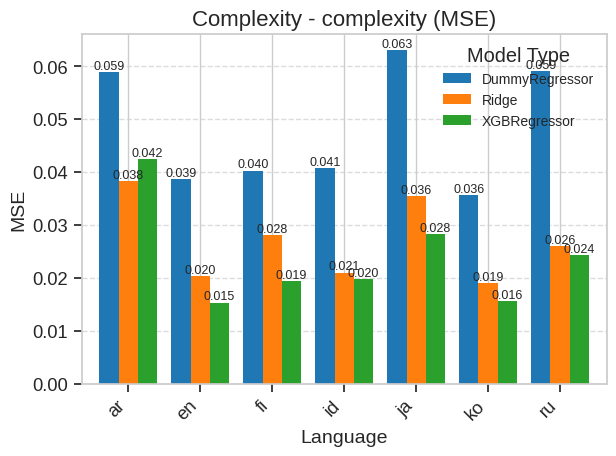

<Figure size 1200x800 with 0 Axes>

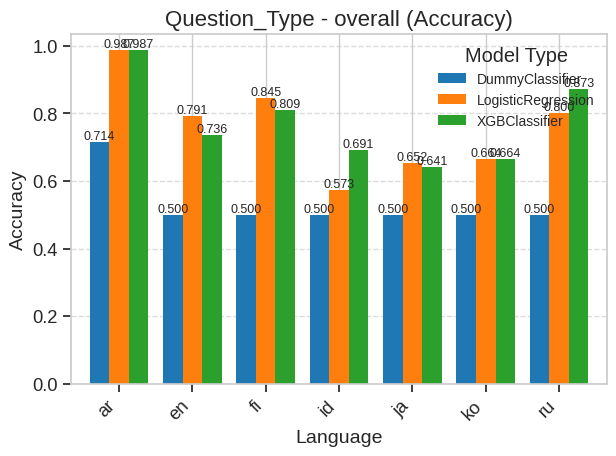

Creating finetuning effectiveness plots...
Analysis complete. All plots have been saved.


In [124]:
df = pd.read_csv('/home/robin/Research/qtype-eval/visualization/notebooks/FINAL_MERGED_RESULTS.csv')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

# Function to create plots for each task type
def plot_performance_by_language(data, task_type):
    """
    Create simple, clean plots showing model performance across languages
    
    Parameters:
    data: pandas DataFrame - the dataset
    task_type: string - 'complexity' or 'question_type'
    """
    # Filter data for the specific task
    task_data = data[data['task'] == task_type]
    
    # Get unique submetrics for this task
    submetrics = task_data['submetric'].unique()
    
    # Get unique metrics (accuracy, mse)
    metrics = task_data['metric'].unique()
    
    # Process each combination of submetric and metric
    for submetric in submetrics:
        for metric in metrics:
            # Filter data for this combination
            filtered_data = task_data[(task_data['submetric'] == submetric) & 
                                      (task_data['metric'] == metric)]
            
            # Skip if no data
            if len(filtered_data) == 0:
                continue
            
            # Get unique languages
            languages = sorted(filtered_data['language'].unique())
            
            # Prepare figure
            plt.figure(figsize=(12, 8))
            
            # Create a grouped bar chart
            grouped_data = filtered_data.groupby(['language', 'model_type'])['real'].mean().reset_index()
            
            # Pivot the data for easier plotting
            pivot_data = grouped_data.pivot(index='language', columns='model_type', values='real')
            
            # Plot the data
            ax = pivot_data.plot(kind='bar', width=0.8)
            
            # Customize the plot
            metric_display = "Accuracy" if metric.lower() == 'accuracy' else "MSE"
            plt.title(f'{task_type.title()} - {submetric} ({metric_display})', fontsize=16)
            plt.xlabel('Language', fontsize=14)
            plt.ylabel(metric_display, fontsize=14)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            
            # Add value labels on top of each bar
            for container in ax.containers:
                ax.bar_label(container, fmt='%.3f', fontsize=9)
            
            # Adjust legend
            plt.legend(title='Model Type', fontsize=10)
            
            # Rotate x-axis labels
            plt.xticks(rotation=45, ha='right')
            
            # Ensure everything fits
            plt.tight_layout()
            
            # Save the figure
            plt.savefig(f'/home/robin/Research/qtype-eval/visualization/figures/simple_{task_type}_{submetric}_{metric}.png', dpi=300, bbox_inches='tight')
            plt.show()
            plt.close()

# Function to create direct comparison plots (finetuned vs. base)
def plot_finetuning_effectiveness(data, task_type):
    """
    Create plots showing the effectiveness of finetuning compared to base model
    
    Parameters:
    data: pandas DataFrame - the dataset
    task_type: string - 'complexity' or 'question_type'
    """
    # Filter data for the specific task
    task_data = data[data['task'] == task_type]
    
    # We're only interested in 'base' and 'finetuned' model types
    model_comparison = task_data[task_data['model_type'].isin(['base', 'finetuned'])]
    
    # Get unique submetrics for this task
    submetrics = model_comparison['submetric'].unique()
    
    # Get unique metrics (accuracy, mse)
    metrics = model_comparison['metric'].unique()
    
    # Process each combination of submetric and metric
    for submetric in submetrics:
        for metric in metrics:
            # Filter data for this combination
            filtered_data = model_comparison[(model_comparison['submetric'] == submetric) & 
                                           (model_comparison['metric'] == metric)]
            
            # Skip if no data
            if len(filtered_data) == 0:
                continue
            
            # Create a comparison table
            comparison_table = pd.pivot_table(
                filtered_data, 
                values='real',
                index='language',
                columns='model_type',
                aggfunc='mean'
            )
            
            # Calculate the improvement
            if 'base' in comparison_table.columns and 'finetuned' in comparison_table.columns:
                if metric.lower() == 'accuracy':
                    # For accuracy, higher is better
                    comparison_table['improvement'] = comparison_table['finetuned'] - comparison_table['base']
                else:
                    # For MSE, lower is better
                    comparison_table['improvement'] = comparison_table['base'] - comparison_table['finetuned']
            else:
                # Skip if we don't have both model types
                continue
            
            # Sort by improvement
            comparison_table = comparison_table.sort_values('improvement', ascending=False)
            
            # Create a horizontal bar chart showing improvement
            plt.figure(figsize=(10, max(6, len(comparison_table) * 0.5)))
            
            # Plot the improvements
            colors = ['green' if x > 0 else 'red' for x in comparison_table['improvement']]
            bars = plt.barh(comparison_table.index, comparison_table['improvement'], color=colors, alpha=0.7)
            
            # Add labels
            plt.xlabel('Improvement' if metric.lower() == 'accuracy' else 'Error Reduction', fontsize=14)
            plt.ylabel('Language', fontsize=14)
            
            metric_display = "Accuracy" if metric.lower() == 'accuracy' else "MSE"
            plt.title(f'Finetuning Effectiveness: {task_type.title()} - {submetric} ({metric_display})', fontsize=16)
            
            # Add values on bars
            for bar in bars:
                width = bar.get_width()
                label_x_pos = width + 0.01 if width > 0 else width - 0.03
                plt.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.3f}', 
                        va='center', fontsize=10, color='black')
            
            # Add a vertical line at x=0
            plt.axvline(x=0, color='black', linestyle='-', alpha=0.7)
            
            # Add grid
            plt.grid(axis='x', linestyle='--', alpha=0.7)
            
            # Add a note about interpretation
            if metric.lower() == 'accuracy':
                note = "Note: Positive values (green) show improvement in accuracy with finetuning"
            else:
                note = "Note: Positive values (green) show reduction in error with finetuning"
                
            plt.figtext(0.5, 0.01, note, ha='center', fontsize=10, 
                      bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
            
            # Ensure everything fits
            plt.tight_layout()
            
            # Save the figure
            plt.savefig(f'/home/robin/Research/qtype-eval/visualization/figures/effectiveness_{task_type}_{submetric}_{metric}.png', dpi=300, bbox_inches='tight')
            plt.show()
            plt.close()

# Execute the functions
print("Creating simple performance plots...")
plot_performance_by_language(df, 'complexity')
plot_performance_by_language(df, 'question_type')

print("Creating finetuning effectiveness plots...")
plot_finetuning_effectiveness(df, 'complexity')
plot_finetuning_effectiveness(df, 'question_type')

print("Analysis complete. All plots have been saved.")